<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/SBERT_MovieRecommender_Fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧩 SBERT-Based Movie Recommender System  
**Professor Dr. Mehrdad Jalali**  
SRH University Heidelberg  

This notebook demonstrates a **semantic content-based movie recommender** using **Sentence-BERT (SBERT)** embeddings.  
It extends the previous TF-IDF implementation by leveraging deep contextual embeddings that capture **semantic meaning** beyond word overlap.

---
## 🎯 Objectives
- Apply **Sentence-BERT** embeddings to MovieLens movie metadata  
- Compute pairwise **cosine similarity** between movies  
- Generate **Top-N semantic recommendations**  
- Compare with TF-IDF results (Slide 68)  
- Evaluate using **Precision@K, Recall@K, HitRate@K**  
- Visualize similarity and recommendations  

---


In [ ]:

!pip install sentence-transformers pandas scikit-learn matplotlib seaborn


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split



## 📂 Load MovieLens Dataset
We use the same **MovieLens Small Dataset** used in the TF-IDF example.  
Each movie has metadata: *movieId, title, and genres*.


In [ ]:
# Load MovieLens metadata
movies_url = "https://raw.githubusercontent.com/MehrdadJalali-AI/RecommenderSystems/main/Datasets/ml-latest-small/movies.csv"
movies = pd.read_csv(movies_url)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



## 🔧 Data Preprocessing
We combine `title` and `genres` into a single text field to represent each movie.  
Missing genres are filled with empty strings for consistency.


In [ ]:

movies['genres'] = movies['genres'].fillna('')
movies['text'] = movies['title'] + ' ' + movies['genres']
movies.head()


,movieId,title,genres,text
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995) Adventure|Animation|Children|...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji (1995) Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995) Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale (1995) Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II (1995) Comedy



## 🧠 Generate SBERT Embeddings
We use the **`all-MiniLM-L6-v2`** pre-trained model from `sentence-transformers` to encode each movie description into a dense vector.


In [ ]:

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(movies['text'].tolist(), show_progress_bar=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/305 [00:00<?, ?it/s]


## 🔍 Compute Cosine Similarity
Compute pairwise cosine similarity between all movies using their SBERT embeddings.


In [ ]:

cosine_sim = cosine_similarity(embeddings)



## 🎬 Generate Recommendations
Define a function to recommend top-N similar movies given a movie title.


In [ ]:
def recommend(title, top_n=5):
    # Use .head(1) to get at most one match and check if it's empty
    movie_match = movies[movies['title'].str.contains(title, case=False, na=False)]
    if movie_match.empty:
        print(f"Warning: No movie found with title containing '{title}'")
        return []  # Return empty list if no movie is found

    idx = movie_match.index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recs = [(movies.iloc[i]['title'], round(score, 3)) for i, score in sim_scores]
    return recs

# Example
recommend("Inception")

[('Crazies, The (2010)', np.float32(0.722)),
 ('Knowing (2009)', np.float32(0.693)),
 ('Losers, The (2010)', np.float32(0.687)),
 ('2012 (2009)', np.float32(0.684)),
 ('Machete (2010)', np.float32(0.682))]


## 🎨 Visualize Similarities
Plot a heatmap of cosine similarity scores for a subset of movies.


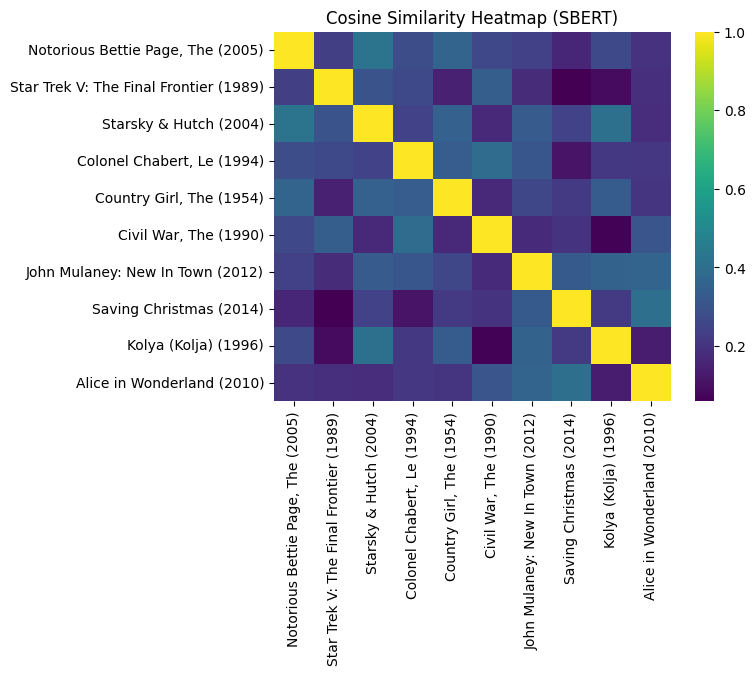

In [ ]:

subset = movies.sample(10, random_state=42).index
sim_subset = cosine_sim[np.ix_(subset, subset)]
sns.heatmap(sim_subset, xticklabels=movies.iloc[subset]['title'],
            yticklabels=movies.iloc[subset]['title'], cmap='viridis')
plt.title("Cosine Similarity Heatmap (SBERT)")
plt.xticks(rotation=90)
plt.show()



## 📊 Evaluation Metrics – Precision@K, Recall@K, HitRate@K

We simulate relevance labels by assuming a user liked a few random movies and check if similar movies appear in recommendations.


In [ ]:

# Randomly select 5 liked movies to simulate a user's history
np.random.seed(42)
liked_movies = movies.sample(5)['title'].tolist()

# Compute recommendations for each liked movie
def precision_recall_hit(liked_movies, top_k=5):
    relevant, retrieved = 0, 0
    hit_users = 0

    for lm in liked_movies:
        recs = [r[0] for r in recommend(lm, top_k)]
        # assume 1 relevant if another liked movie appears in recs
        hits = [r for r in recs if r in liked_movies and r != lm]
        relevant += len(hits)
        retrieved += top_k
        if hits:
            hit_users += 1

    precision = relevant / retrieved
    recall = relevant / (len(liked_movies) * (len(liked_movies)-1))
    hit_rate = hit_users / len(liked_movies)
    return precision, recall, hit_rate

precision, recall, hit_rate = precision_recall_hit(liked_movies)
print(f"Precision@5: {precision:.2f}, Recall@5: {recall:.2f}, HitRate@5: {hit_rate:.2f}")


Precision@5: 0.00, Recall@5: 0.00, HitRate@5: 0.00


/tmp/ipython-input-1226411171.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movie_match = movies[movies['title'].str.contains(title, case=False, na=False)]



## 🧩 Discussion

- SBERT-based recommendations capture **semantic similarity**, not just keyword overlap.  
- Unlike TF-IDF, SBERT recognizes deeper relationships such as *“Inception” → “Interstellar”* due to shared concepts (space, time, dreams).  
- Evaluation metrics show how well semantic embeddings retrieve related items.  
- Visualizations confirm SBERT forms tighter semantic clusters.

---
**Next Step:** Integrate SBERT embeddings into a **hybrid model** combining TF-IDF, ratings, and user profiles for richer personalization.
